<a href="https://colab.research.google.com/github/franciscobarber/notebooks/blob/sound/Copy_of_net_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -l -s https://franciscobarber@github.com/franciscobarber/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4237, done.
remote: Counting objects: 100% (4237/4237), done.
remote: Compressing objects: 100% (4111/4111), done.
remote: Total 4237 (delta 123), reused 4237 (delta 123), pack-reused 0
Receiving objects: 100% (4237/4237), 30.34 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [83]:
!pip install pydub

In [84]:
import tensorflow as tf
import tensorflow_datasets as tfds
import IPython.display as ipd


def load():
  #train_dataset = tfds.load('ljspeech')
  #ds = train_dataset['train']

  train_dataset = tfds.load('ljspeech', split=['train[2%:]'])
  ds = train_dataset[0]
  print(len(train_dataset))
  temp = list(map(lambda x: x['speech'], ds))

  dataset =list( map(lambda x: x.numpy(), temp))
  del temp
  del ds
  return dataset
dataset = load()
import gc
gc.collect()
print(dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ljspeech/1.1.1.incompleteXVSNJD/ljspeech-train.tfrecord*...:   0%|        …

Dataset ljspeech downloaded and prepared to /root/tensorflow_datasets/ljspeech/1.1.1. Subsequent calls will reuse this data.
1
[array([289, 364, 155, ...,   5,  -6,  -8], dtype=int16), array([ 5,  0,  2, ..., 28, 29, 27], dtype=int16), array([-23, -25, -28, ...,  27,  23,  22], dtype=int16), array([-46, -45, -37, ...,  -7, -14, -14], dtype=int16), array([  4,   6,   8, ..., -10,  -3,  -4], dtype=int16), array([-25, -18, -20, ..., -15, -18, -22], dtype=int16), array([111, 218, 115, ..., -22, -18, -11], dtype=int16), array([ 90, -58,  31, ..., -20, -14, -14], dtype=int16), array([31, 28, 23, ...,  0,  1, -8], dtype=int16), array([  3,  -9, -18, ...,  14,  23,  28], dtype=int16), array([ 4,  7,  5, ..., 36, 37, 40], dtype=int16), array([-29, -25, -15, ...,   6,   7,   2], dtype=int16), array([-11, -11,  -9, ...,  41, -33, -59], dtype=int16), array([ 10, 237, 116, ..., -24,  43,  52], dtype=int16), array([ -7, -14, -10, ...,  25,  14,  12], dtype=int16), array([43, 44, 46, ..., 41, 16, 50]

In [ ]:
!pip install "torch>=2.0<3.0" #2.0.1
!pip install pesq
!pip install "torchmetrics>=1.0<2.0" #1.0.2
!pip install "keras>=2.0<3.0" #2.12.0
!pip install "tensorflow>=2.0<3.0" #2.12.0
!pip install git+https://github.com/yoyololicon/spectrogram-inversion

In [3]:
#@title Biblioteca espectrograma
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out


def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram


# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(
    X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10
):

    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset

import scipy.io.wavfile as wav

### Parameters ###
fft_size = 512  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)
lowcut = 500  # Hz # Low cut for our butter bandpass filter
highcut = 4000  # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64  # number of mel frequency channels
shorten_factor = 10  # how much should we compress the x-axis (time)
start_freq = 50  # Hz # What frequency to start sampling our melS from
end_freq = 4000
audio_path='/content/free-spoken-digit-dataset/recordings/0_jackson_0.wav'
data_rate, data = wav.read(audio_path)
wav_spectrogram = pretty_spectrogram(
data.astype("float64"),
fft_size=fft_size,
step_size=step_size,
log=True,
thresh=spec_thresh,
)

# Invert from the spectrogram back to a waveform
recovered_audio_orig = invert_pretty_spectrogram(
    wav_spectrogram, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)

In [89]:
import time
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten, BatchNormalization, Dropout
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras import regularizers
import torch
from torchmetrics.audio import PerceptualEvaluationSpeechQuality
from torch_specinv import griffin_lim
np.random.seed(1337)

class myautoencoder():
  def __init__(self,compression_rate,linear_encoder, fft, time_long,fft_step_size_ratio, x_train, x_test, clip, mode = 'conv', pretrain_encoder = False, encoder_w=None):
    self.linear_encoder = linear_encoder
    self.mode = mode
    self.time_long = int(time_long)
    #modif
    self.x_train = x_train
    self.x_test = x_test
    self.fft = fft
    self.step_size = int(fft/fft_step_size_ratio)
    self.time = int(self.time_long/self.step_size)
    self.clip = clip
    self.encoder_w = encoder_w
    image_size= self.x_train.shape
    self.compression_rate = compression_rate
    self.x_train = np.reshape(self.x_train, [-1, image_size[1], image_size[2], 1])

    self.x_test = np.reshape(self.x_test, [-1, image_size[1], image_size[2], 1])
    self.x_train = self.x_train.astype('float32') / self.clip
    self.x_test = self.x_test.astype('float32') / self.clip

    # Network parameters
    input_shape = (image_size[1], image_size[2], 1)
    self.batch_size = 32
    kernel_size = (int(10*self.fft/512),int(5*self.time/16))
    latent_dim =int(self.compression_rate*self.time_long)
    # Encoder/Decoder number of CNN layers and filters per layer
    layer_filters = [16, 32]
    # Build the Autoencoder Model
    # First build the Encoder Model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    # Shape info needed to build Decoder Model
    shape = K.int_shape(x)
    if mode == 'conv':
      shape = (None,int(self.fft/2), int(self.time_long/self.step_size),int(self.time_long/(self.step_size*2)))
    else:
      shape = (None,int(self.fft/2)+1, int(self.time_long/self.step_size),1)
    # Generate the latent vector
    x = Flatten()(inputs)
    if self.linear_encoder == True:
      activation = 'linear'
    else:
      activation = 'tanh'

    self.layer = Dense(latent_dim, activation=activation, name='latent_vector')
    latent = self.layer(x)

    if pretrain_encoder == True:
      self.layer.set_weights(self.encoder_w)
      self.layer.trainable = False

    # Instantiate Encoder Model
    encoder = Model(inputs, latent, name='encoder')
    #encoder.summary()
    # Build the Decoder Model
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    if self.mode == 'mlp1':
      x = Dense(500, activation="relu")(x)
    if self.mode == 'mlp2':
      x = Dense(500, activation="sigmoid")(x)
      x = BatchNormalization()(x)
      x = Dense(500, activation="sigmoid")(x)
      x = BatchNormalization()(x)
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    lp = x
    '''
    x = Conv2DTranspose(filters=1,
                        kernel_size=(5,5),
                        padding='same')(x)
    '''
    #x2 = x
    # Stack of Transposed Conv2D blocks
    # Notes:
    # 1) Use Batch Normalization before ReLU on deep networks
    # 2) Use UpSampling2D as alternative to strides>1
    # - faster but not as good as strides>1

    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            kernel_regularizer=regularizers.l2(0.001),
                            strides=(1,1),
                            activation='relu',
                            padding='same')(x)


    conv = Conv2DTranspose(filters=1,
                        kernel_size=kernel_size,
                        padding='same')(x)

    if self.mode == 'conv':
      x2 = conv
    elif self.mode == 'mlp1' or self.mode == 'mlp2':
      x2 = lp

    outputs = Activation('sigmoid', name='decoder_output')(x2)

    # Instantiate Decoder Model
    decoder = Model(latent_inputs, outputs, name='decoder')
    #decoder.summary()

    # Autoencoder = Encoder + Decoder
    # Instantiate Autoencoder Model
    self.autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
  def train(self, epochs, loss):
    t0 = time.time()
    self.epochs = epochs
    self.loss = loss
    #autoencoder.summary()
    sgd = keras.optimizers.Adam(lr=0.0001, beta_1=0.95, beta_2=0.999, amsgrad=False)
    #sgd = keras.optimizers.RMSprop(lr=0.0001, rho=0.99)
    self.autoencoder.compile(loss=self.loss, optimizer=sgd)

    # Train the autoencoder
    history = self.autoencoder.fit(x = self.x_train,
                    y = self.x_train,
                    validation_data=(self.x_test,self.x_test), verbose=0,
                    epochs=self.epochs,
                    batch_size=self.batch_size)
    if self.mode == 'lp':
      self.encoder_w=self.layer.get_weights()
    # Plot training & validation loss values
    print(time.time()-t0)
    return self.encoder_w, history
#autoencoder.evaluate(self.x_test,self.x_test)
#g = autoencoder
#g2_json = g.to_json()
#1 3000
#2 10000
#with open("/gdrive/My Drive/NN/auto-256cnn.json", "w") as json_file:
#    json_file.write(g2_json)
# serialize weights to HDF5
#g.save_weights("/gdrive/My Drive/NN/auto-256cnn.h5")
#print("Saved model g to disk")
  def audio_evaluation(self, num_audios, log_ref):
    self.log_ref = log_ref
    sp_sz = int(self.time_long)
    loss1 = np.zeros(num_audios,)
    loss2 = np.zeros(num_audios,)
    loss3 = np.zeros(num_audios,)
    loss4 = []
    SMSE = []
    p = []
    pearson = []
    pearson_s = []
    SNR = np.zeros(num_audios,)
    t0 = time.time()
    total_specs=0
    audio_dir='/content/free-spoken-digit-dataset/recordings/'
    file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]
    for i in range(num_audios):

      audio_path = audio_dir + file_names[int(i+np.ceil(len(file_names)*.8))]
      sample_rate, samples = wav.read(audio_path)
      samples = np.append(samples, np.random.randn(sp_sz-samples.shape[0]%sp_sz)*10, axis=0)

      y = torch.from_numpy(samples.astype("float32"))
      windowsize = 256
      window = torch.hann_window(windowsize)
      S = torch.stft(y, windowsize, window=window, return_complex=False)
      mag = S.pow(2).sum(2).sqrt()
      num = mag.numpy()

      ms=librosa.power_to_db(num, ref=self.log_ref)
      n_ms = samples.shape[0]//sp_sz
      ms = ms[:,:(n_ms*16)]
      ms2 = np.expand_dims(ms, axis=0)
      lms = np.split(ms2, n_ms, axis=2)
      ms2 = np.concatenate(lms)
      msrs = np.reshape(ms2/self.clip, [-1, ms2.shape[1], ms2.shape[2], 1])


      #decrypt
      x_decoded = self.autoencoder.predict(msrs)
      lms = np.split(x_decoded, x_decoded.shape[0], axis=0)
      x_decoded2 = np.concatenate(lms,axis=2)
      x_decoded3 = np.reshape(x_decoded2, [ x_decoded2.shape[1], x_decoded2.shape[2]])*self.clip
      comp3 = librosa.core.db_to_power(x_decoded3, ref=self.log_ref)
      #print('shape', num.shape)



      try:
        yhat = griffin_lim(torch.from_numpy(comp3), maxiter=100, alpha=0.3, window=window)
        #mag = trsfn(y)
      #yhat = RTISI_LA(mag, look_ahead=-1, asymmetric_window=False, max_iter=25,
      #alpha=0.99, verbose=1)

        # check convergence

        g = torch.manual_seed(1)
        preds = torch.from_numpy(samples)
        nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')
        yhatn=yhat.numpy()
        pesq_value = nb_pesq(yhat.type('torch.ShortTensor'), preds[:yhatn.shape[0]]).float()
        p.append(pesq_value)

        b =  pretty_spectrogram(samples[:yhatn.shape[0]].astype("float32")
            ,fft_size=self.fft,step_size=self.step_size,log=False)
        c =  pretty_spectrogram(yhatn.astype("float32")
          ,fft_size=self.fft,step_size=self.step_size,log=False)
        pearson_s.append(scipy.stats.pearsonr(b.reshape(-1),c.reshape(-1)).statistic)
        pearson.append(scipy.stats.pearsonr(samples[:yhatn.shape[0]],yhatn).statistic)
        p.append(pesq_value)
        SMSE.append(np.linalg.norm(b-c)/np.linalg.norm(b))

      except:
        pass

    print('PESQ',sum(p)/len(p))
    print('PEARSON SPECTRAL',sum(pearson_s)/len(pearson_s))
    print('PEARSON',sum(pearson)/len(pearson))
    print('SMSE',sum(SMSE)/len(SMSE))
    print( 'tiempo de reconstrucción: {}s'.  format(int(time.time()-t0)))
  def audio_hearing(self, audio_name):
    sp_sz = int(self.time_long)

    audio_dir='/content/free-spoken-digit-dataset/recordings/'
    file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]

    audio_path = audio_dir + audio_name
    sample_rate, samples = wav.read(audio_path)
    samples = np.append(samples, np.random.randn(sp_sz-samples.shape[0]%sp_sz)*10, axis=0)

    y = torch.from_numpy(samples.astype("float32"))
    windowsize = 256
    window = torch.hann_window(windowsize)
    S = torch.stft(y, windowsize, window=window, return_complex=False)
    mag = S.pow(2).sum(2).sqrt()
    num = mag.numpy()

    ms=librosa.power_to_db(num, ref=self.log_ref)
    n_ms = samples.shape[0]//sp_sz
    ms = ms[:,:(n_ms*16)]
    ms2 = np.expand_dims(ms, axis=0)
    lms = np.split(ms2, n_ms, axis=2)
    ms2 = np.concatenate(lms)
    msrs = np.reshape(ms2/self.clip, [-1, ms2.shape[1], ms2.shape[2], 1])


    #decrypt
    x_decoded = self.autoencoder.predict(msrs)
    lms = np.split(x_decoded, x_decoded.shape[0], axis=0)
    x_decoded2 = np.concatenate(lms,axis=2)
    x_decoded3 = np.reshape(x_decoded2, [ x_decoded2.shape[1], x_decoded2.shape[2]])*self.clip
    comp3 = librosa.core.db_to_power(x_decoded3, ref=self.log_ref)
    #print('shape', num.shape)



    try:
      yhat = griffin_lim(torch.from_numpy(comp3), maxiter=100, alpha=0.3, window=window)
      #mag = trsfn(y)
    #yhat = RTISI_LA(mag, look_ahead=-1, asymmetric_window=False, max_iter=25,
    #alpha=0.99, verbose=1)

      return yhat.numpy()

    except:
      pass

In [87]:
from os import listdir
import scipy.io.wavfile as wav
from os.path import isfile, join
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
def create_specs(fft, time_long, step_size, log_ref):
  audio_dir='/content/free-spoken-digit-dataset/recordings/'
  file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]
  ms_list = np.zeros([0,int(fft/2)+1,int(time_long/step_size)])

  #sp_sz=2046
  sp_sz = int(time_long)
  i = 0
  for file_name in file_names:
    i += 1
    audio_path = audio_dir + file_name

    sample_rate, samples = wav.read(audio_path)
    samples = np.append(samples, np.random.randn(sp_sz-samples.shape[0]%sp_sz)*10, axis=0)
    #ms = np.transpose(pretty_spectrogram(samples.astype("float32"),fft_size=fft,step_size=step_size,log=False))
    #n_ms = samples.shape[0]//sp_sz
    #ms = np.expand_dims(librosa.power_to_db(ms,
    #                                        ref=log_ref), axis=0)
    y = torch.from_numpy(samples.astype("float32"))
    windowsize = 256
    window = torch.hann_window(windowsize)
    S = torch.stft(y, windowsize, window=window, return_complex=False)


    # discard phase information
    mag = S.pow(2).sum(2).sqrt()
    ms = mag.numpy()
    n_ms = samples.shape[0]//sp_sz
    ms = ms[:,:(n_ms*16)]
    ms = np.expand_dims(librosa.power_to_db(ms,
                                            ref=log_ref), axis=0)
    lms = np.split(ms, n_ms, axis=2)
    ms2 = np.concatenate(lms)
    ms_list = np.append(ms_list,ms2,axis=0)
  print(np.amin(ms_list))
  print(np.amax(ms_list))
  return  train_test_split(
    ms_list, test_size=0.20, random_state=42)

In [88]:
fft = 256
time_long = 1024
step_size = 64
fft_step_size_ratio = int(fft/step_size)
log_ref = 5e-0
X_train, X_test = create_specs(fft=fft, time_long=time_long, step_size= step_size, log_ref= log_ref)

-34.52760696411133
54.47087097167969


In [44]:
print(X_train.shape)

(9416, 129, 16)


In [91]:
compression_rate= 0.125
clip=np.ceil(np.amax(X_train))
print(clip)
conv = myautoencoder(compression_rate= compression_rate, linear_encoder= True, fft = fft, time_long= time_long,
                    fft_step_size_ratio= fft_step_size_ratio, x_train=X_train, x_test=X_test, clip=57, mode='mlp2', pretrain_encoder=False)
encoder_w, historyconv= conv.train(100, 'mse')
conv.audio_evaluation(20, log_ref= log_ref)


55.0


143.16116642951965
1/1 [==============================] - 0s 52ms/step


100%|██████████| 200/200 [00:00<00:00, 925.44it/s, SC=-17.4, loss=8.25e+4]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 990.35it/s, SC=-18, loss=9.87e+4]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 949.42it/s, SC=-17.6, loss=3.05e+4]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 822.29it/s, SC=-15.3, loss=6.07e+6]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 874.88it/s, SC=-17.5, loss=1.67e+7]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 1124.44it/s, SC=-17.9, loss=1.59e+5]


1/1 [==============================] - 0s 22ms/step


100%|██████████| 200/200 [00:00<00:00, 907.88it/s, SC=-19.1, loss=4.13e+6]


1/1 [==============================] - 0s 19ms/step


100%|██████████| 200/200 [00:00<00:00, 756.10it/s, SC=-16.9, loss=6.08e+6]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 1018.90it/s, SC=-14.7, loss=4.3e+5]


1/1 [==============================] - 0s 20ms/step


100%|██████████| 200/200 [00:00<00:00, 983.95it/s, SC=-17.6, loss=1.96e+4]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 895.13it/s, SC=-17.8, loss=2.43e+5]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 876.09it/s, SC=-15.5, loss=2.47e+6]


1/1 [==============================] - 0s 19ms/step


100%|██████████| 200/200 [00:00<00:00, 857.66it/s, SC=-18.5, loss=7.41e+6]


1/1 [==============================] - 0s 19ms/step


100%|██████████| 200/200 [00:00<00:00, 1146.76it/s, SC=-18.2, loss=3.68e+4]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 840.52it/s, SC=-18.7, loss=3.14e+6]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 957.44it/s, SC=-17.2, loss=3.45e+6]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 1076.96it/s, SC=-17.3, loss=7.55e+4]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 836.89it/s, SC=-19.3, loss=7.34e+6]


1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 855.11it/s, SC=-21, loss=6.84e+6]


1/1 [==============================] - 0s 17ms/step


100%|██████████| 200/200 [00:00<00:00, 833.58it/s, SC=-18.3, loss=4.47e+6]


PESQ tensor(3.3762)
PEARSON SPECTRAL 0.9215604526148973
PEARSON 0.08047423635700017
SMSE 0.3787324371484185
tiempo de reconstrucción: 6s


In [16]:
import time
conv.audio_evaluation(10, log_ref= log_ref)

1/1 [==============================] - 0s 28ms/step
LOSS 0.6812429001358418
LOSS2 1428667.1045592483


ZeroDivisionError: division by zero

In [92]:
audio = conv.audio_hearing("5_george_2.wav")
#log_ref=1e-0
IPython.display.Audio(data=audio, rate=9000)

1/1 [==============================] - 0s 18ms/step


100%|██████████| 200/200 [00:00<00:00, 860.92it/s, SC=-19.3, loss=1.71e+6]


In [93]:
sample_rate, samples = wav.read('/content/free-spoken-digit-dataset/recordings/5_george_2.wav')
IPython.display.Audio(data=audio, rate=9000)

In [ ]:
wavfile.write('five.wav', 8000, audio)

In [ ]:
compression_rate= 0.125
clip=np.ceil(np.amax(X_train))
print(clip)
mlp1 = myautoencoder(compression_rate= compression_rate, linear_encoder= True, fft = fft, time_long= time_long,
                    fft_step_size_ratio= fft_step_size_ratio, x_train=X_train, x_test=X_test, clip=57, mode='mlp1', pretrain_encoder=False)
encoder_w, historymlp1= mlp1.train(700, 'mse')
mlp1.audio_evaluation(800, log_ref= log_ref)


55.0
694.6065850257874
LOSS 0.6817622973348679
LOSS2 1345244.117565388
SNR 0.8656589974277538
5851
tiempo de reconstrucción: 177s


In [ ]:
audio, sample_rate = mlp1.make_wav(number=5,person=2, repetition=16)
#log_ref=1e-0
IPython.display.Audio(data=audio, rate=sample_rate)

In [ ]:
compression_rate= 0.125
clip=np.ceil(np.amax(X_train))
print(clip)
mlp2 = myautoencoder(compression_rate= compression_rate, linear_encoder= True, fft = fft, time_long= time_long,
                    fft_step_size_ratio= fft_step_size_ratio, x_train=X_train, x_test=X_test, clip=57, mode='mlp2', pretrain_encoder=False)
encoder_w, historymlp2= mlp2.train(700, 'mse')
mlp2.audio_evaluation(800, log_ref= log_ref)

55.0
682.9130940437317
LOSS 0.6782945632893066
LOSS2 1317326.2305856186
SNR 0.8589740629830659
5775
tiempo de reconstrucción: 175s


In [ ]:
audio, sample_rate = mlp2.make_wav(number=5,person=2, repetition=16)
#log_ref=1e-0
IPython.display.Audio(data=audio, rate=sample_rate)

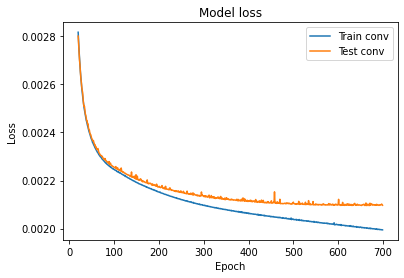

In [ ]:
finish= 700
plt.plot(range(20,finish),historyconv.history['loss'][20:])
plt.plot(range(20,finish),historyconv.history['val_loss'][20:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train conv', 'Test conv',  ], loc='best')
plt.show()

In [ ]:
clip=np.ceil(np.amax(X_train))
print(clip)
lp2 = myautoencoder(compression_rate= compression_rate, linear_encoder= False, fft = fft, time_long= time_long,
                    fft_step_size_ratio= fft_step_size_ratio, x_train=X_train, x_test=X_test, clip=57, mode='lp', pretrain_encoder=False)
encoder_w, historylp2= lp2.train(700, 'mse')
lp2.audio_evaluation(800, log_ref= log_ref)

55.0


UnboundLocalError: ignored

In [ ]:

plt.plot(range(300,800),historylp1.history['loss'][300:])
plt.plot(range(300,800),historylp1.history['val_loss'][300:])
plt.plot(range(300,800),historylp2.history['loss'][300:])
plt.plot(range(300,800),historylp2.history['val_loss'][300:])
#plt.plot(range(300,800),historylp4.history['loss'][300:])
#plt.plot(range(300,800),historylp4.history['val_loss'][300:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#'Train-tanh', 'Test-tanh'
plt.legend(['Train-linear', 'Test-linear', 'Train-relu', 'Test-relu'], loc='upper left')
plt.show()

In [ ]:
lp1.audio_evaluation(800, log_ref= log_ref)
lp2.audio_evaluation(800, log_ref= log_ref)

In [ ]:
lp3.audio_evaluation(800, log_ref= log_ref)

In [ ]:
audio, sample_rate = lp1.make_wav(number=5,person=2, repetition=16)
#log_ref=1e-0
IPython.display.Audio(data=audio, rate=sample_rate)

In [ ]:
audio, sample_rate = lp3.make_wav(number=5,person=2, repetition=16)
#log_ref=1e-0
IPython.display.Audio(data=audio, rate=sample_rate)

In [ ]:
clip=np.ceil(np.amax(X_train))
print(clip)
lp4 = myautoencoder(compression_rate= compression_rate, linear_encoder= False, fft = fft, time_long= time_long,
                    fft_step_size_ratio= fft_step_size_ratio, x_train=X_train, x_test=X_test, clip=57, mode='lp', pretrain_encoder=False)
encoder_w, historylp4= lp4.train(800, 'mse')
lp4.audio_evaluation(800, log_ref= log_ref)